In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m3 import M3
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS
from neuralforecast.tsdataset import TimeSeriesDataset
import matplotlib.pyplot as plt


# Load the M3 dataset
m3 = M3.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\', group='Monthly')[0]

# m4['ds'] = pd.to_datetime(m4['ds']).astype(int)

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-23 22:12:55,323	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-23 22:12:55,578	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18
input_size = 24

In [4]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except Exception as exc:
        y_hat = Y_hat_df
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

In [5]:
y_train, y_test = train_test_split(m3, horizon)

prob_collector = GateValuesCollectorCallback(is_stack=True, reset_on_epoch=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            mlp_units = 3 * [[256, 256]],
        ),
        NBEATS(
            input_size=input_size, 
            h=horizon,
            mlp_units = 3 * [[256, 256]],
        ),
    ], 
    freq='M',
)
nf.fit(df=y_train, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=y_test)

smape_stack= calculate_smape(y_test, predictions, 'NBeatsStackMoe')
print(f'sMAPE for stack: {smape_stack}')
smape_nbeats= calculate_smape(y_test, predictions, 'NBEATS')
print(f'sMAPE for NBEATS: {smape_nbeats}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 642 K  | train
4 | gate         | Sequential    | 123    | train
-------------------------------------------------------
641 K     Trainable params
1.6 K     Non-trainable params
642 K     Total params
2.571     Total estimated mod

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 13.79it/s, v_num=86, train_loss_step=509.0, train_loss_epoch=598.0, valid_loss=660.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 13.79it/s, v_num=86, train_loss_step=509.0, train_loss_epoch=598.0, valid_loss=660.0]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 642 K  | train
-------------------------------------------------------
641 K     Trainable params
1.6 K     Non-trainable params
642 K     Total params
2.571     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.36it/s, v_num=87, train_loss_step=503.0, train_loss_epoch=593.0, valid_loss=663.0] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.36it/s, v_num=87, train_loss_step=503.0, train_loss_epoch=593.0, valid_loss=663.0]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 148.46it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 149.60it/s]
sMAPE for stack: 0.13844556782715198
sMAPE for NBEATS: 0.13857288754442124


In [6]:
y_hats = []

for i, model in enumerate(nf.models):
    dataset, *_ = TimeSeriesDataset.from_df(df = y_train)
    y_hat = model.decompose(dataset=dataset)

    y_hats.append(y_hat)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 144.47it/s]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 148.59it/s]


0
[[ 2.40000000e+03  2.40000000e+03  2.40000000e+03  2.40000000e+03
   2.40000000e+03  2.40000000e+03  2.40000000e+03  2.40000000e+03
   2.40000000e+03  2.40000000e+03  2.40000000e+03  2.40000000e+03
   2.40000000e+03  2.40000000e+03  2.40000000e+03  2.40000000e+03
   2.40000000e+03  2.40000000e+03]
 [ 6.19226418e+01 -2.61904392e+01 -6.17278938e+01 -5.85254669e+01
   4.60428848e+01  4.20538750e+01  1.38875229e+02  1.12301323e+02
   3.30196686e+02  2.89330078e+02 -2.89157944e+01 -1.01703995e+02
  -4.53407021e+01 -4.72419395e+01 -1.42925278e+02 -1.32782990e+02
  -2.27398548e+01 -8.79704514e+01]
 [-1.66044044e+01 -1.19898252e+01 -7.52765322e+00 -3.21788907e+00
   9.39466715e-01  4.94441652e+00  8.79695702e+00  1.24970903e+01
   1.60448151e+01  1.94401321e+01  2.26830463e+01  2.57735443e+01
   2.87116394e+01  3.14973221e+01  3.41306076e+01  3.66114769e+01
   3.89399414e+01  4.11159973e+01]
 [-3.13205627e+02 -2.46599152e+02 -4.28188629e+02 -2.86577789e+02
  -2.01404953e+02 -2.82987610e+02  

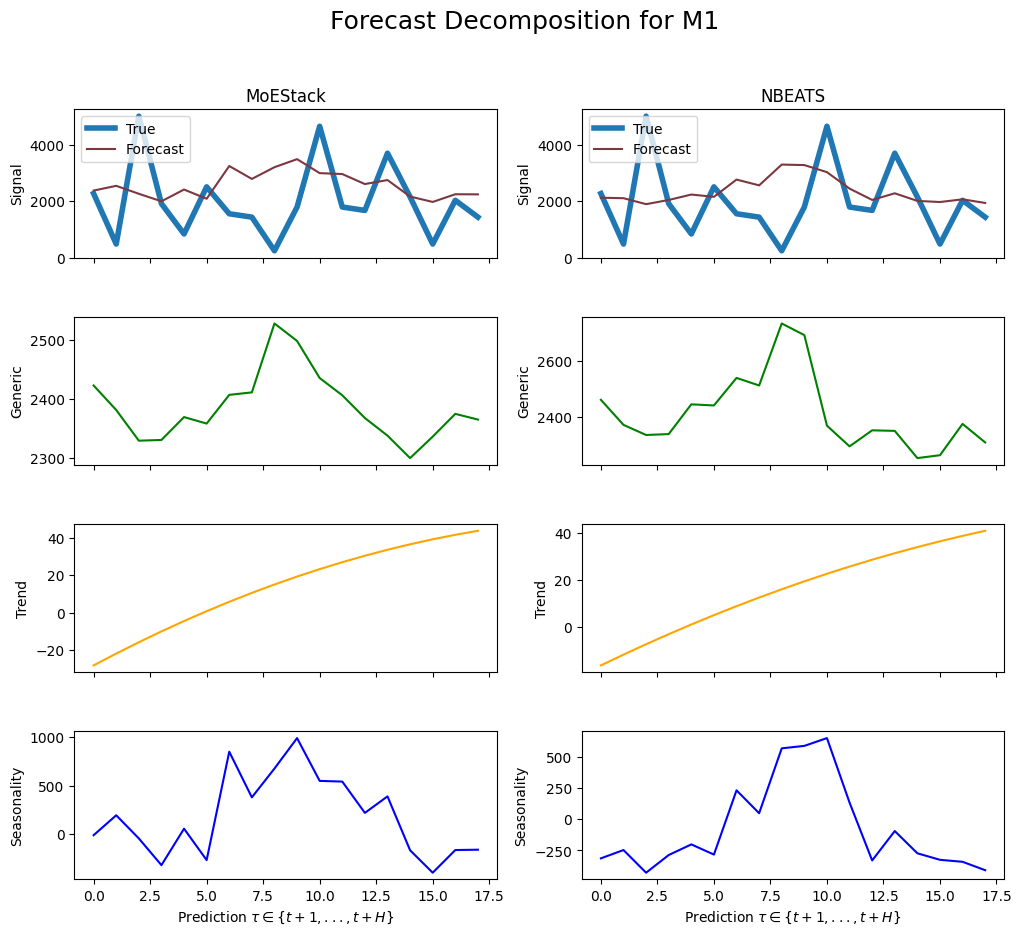

   unique_id         ds       y
0         M1 1994-03-31  2280.0
1         M1 1994-04-30   480.0
2         M1 1994-05-31  5040.0
3         M1 1994-06-30  1920.0
4         M1 1994-07-31   840.0
5         M1 1994-08-31  2520.0
6         M1 1994-09-30  1560.0
7         M1 1994-10-31  1440.0
8         M1 1994-11-30   240.0
9         M1 1994-12-31  1800.0
10        M1 1995-01-31  4680.0
11        M1 1995-02-28  1800.0
12        M1 1995-03-31  1680.0
13        M1 1995-04-30  3720.0
14        M1 1995-05-31  2160.0
15        M1 1995-06-30   480.0
16        M1 1995-07-31  2040.0
17        M1 1995-08-31  1440.0
450
[[ 6.76060010e+03  6.76060010e+03  6.76060010e+03  6.76060010e+03
   6.76060010e+03  6.76060010e+03  6.76060010e+03  6.76060010e+03
   6.76060010e+03  6.76060010e+03  6.76060010e+03  6.76060010e+03
   6.76060010e+03  6.76060010e+03  6.76060010e+03  6.76060010e+03
   6.76060010e+03  6.76060010e+03]
 [ 1.78659496e+01  1.62396526e+01  7.36580610e+00 -2.58021507e+01
  -4.03753433e+01 -1.64

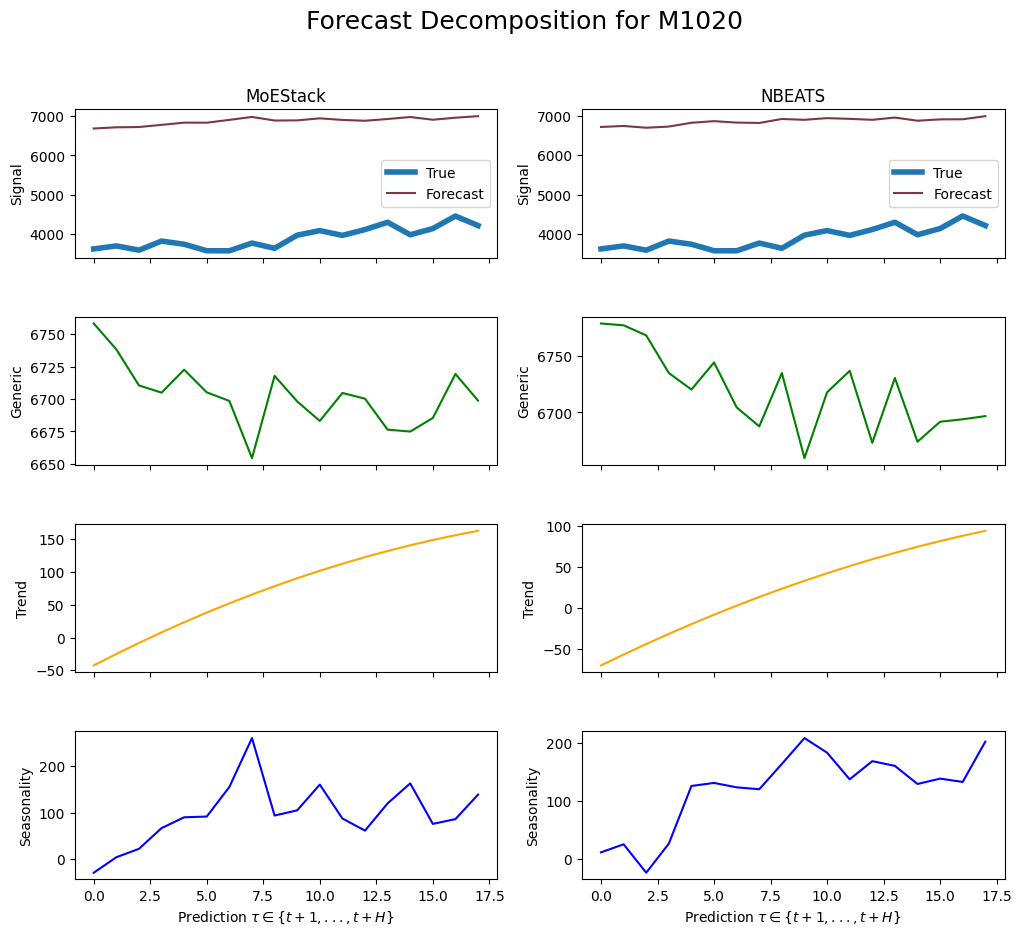

    unique_id         ds       y
450     M1020 1992-09-30  3624.0
451     M1020 1992-10-31  3700.2
452     M1020 1992-11-30  3591.8
453     M1020 1992-12-31  3823.6
454     M1020 1993-01-31  3742.4
455     M1020 1993-02-28  3577.2
456     M1020 1993-03-31  3576.2
457     M1020 1993-04-30  3772.4
458     M1020 1993-05-31  3639.4
459     M1020 1993-06-30  3973.0
460     M1020 1993-07-31  4089.6
461     M1020 1993-08-31  3967.8
462     M1020 1993-09-30  4116.2
463     M1020 1993-10-31  4300.8
464     M1020 1993-11-30  3983.8
465     M1020 1993-12-31  4140.6
466     M1020 1994-01-31  4460.0
467     M1020 1994-02-28  4217.6
18
[[ 6.0003501e+03  6.0003501e+03  6.0003501e+03  6.0003501e+03
   6.0003501e+03  6.0003501e+03  6.0003501e+03  6.0003501e+03
   6.0003501e+03  6.0003501e+03  6.0003501e+03  6.0003501e+03
   6.0003501e+03  6.0003501e+03  6.0003501e+03  6.0003501e+03
   6.0003501e+03  6.0003501e+03]
 [ 9.2372990e+00  1.7312872e+01  2.4020801e+00 -1.0179275e+01
  -1.2458485e+01 -9.0860062

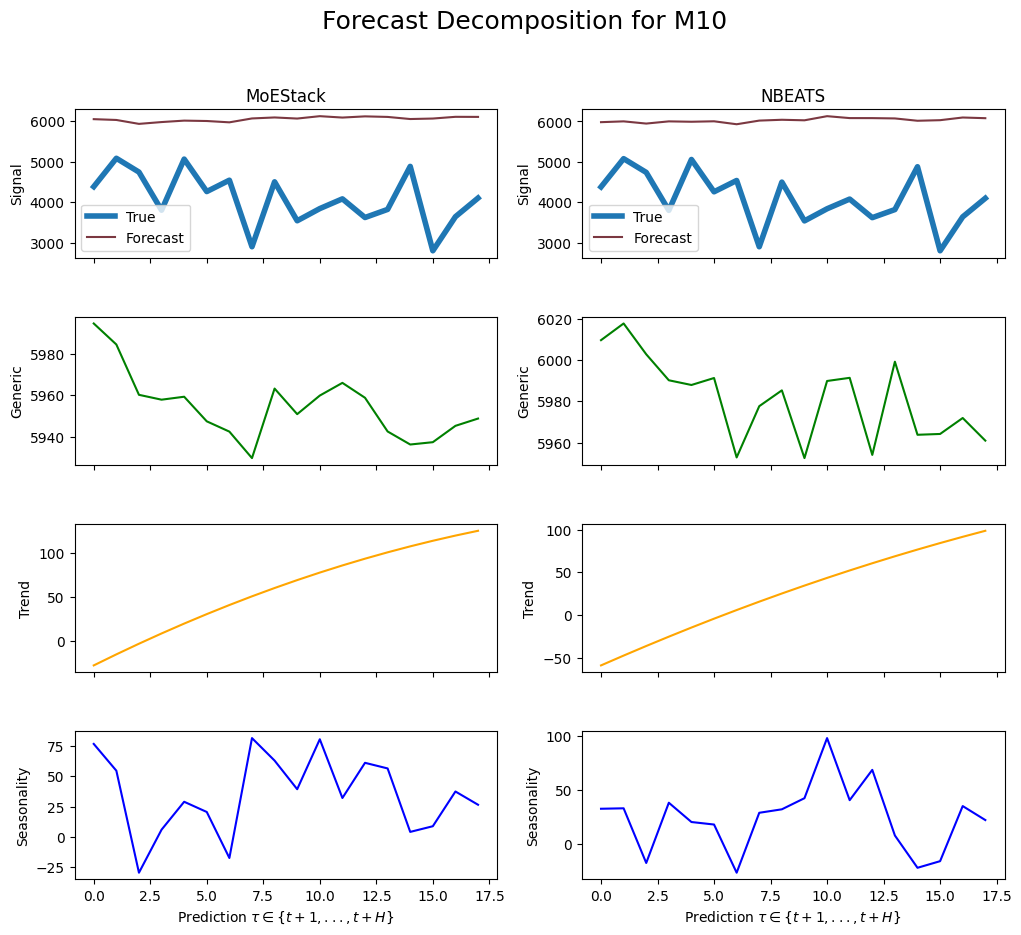

   unique_id         ds       y
18       M10 1994-03-31  4380.0
19       M10 1994-04-30  5080.0
20       M10 1994-05-31  4740.0
21       M10 1994-06-30  3800.0
22       M10 1994-07-31  5060.0
23       M10 1994-08-31  4260.0
24       M10 1994-09-30  4540.0
25       M10 1994-10-31  2900.0
26       M10 1994-11-30  4500.0
27       M10 1994-12-31  3540.0
28       M10 1995-01-31  3840.0
29       M10 1995-02-28  4080.0
30       M10 1995-03-31  3620.0
31       M10 1995-04-30  3820.0
32       M10 1995-05-31  4880.0
33       M10 1995-06-30  2800.0
34       M10 1995-07-31  3640.0
35       M10 1995-08-31  4100.0


In [8]:
to_check_ids = ['M1', 'M1020', "M10"]
enumerate_models = ['MoEStack', 'NBEATS']

for i, id in enumerate(to_check_ids):

    # select unique_id M1
    m_id = y_test[y_test['unique_id'] == id]
    m_idex = y_test[y_test['unique_id'] == id].index[0]

    # Shared figure: 4 rows (plot types) x N models (columns)
    fig, ax = plt.subplots(4, len(enumerate_models), figsize=(12, 10), sharex=True)
    fig.suptitle(f'Forecast Decomposition for {id}', fontsize=18)
    fig.subplots_adjust(hspace=0.4)

    print(m_idex)
    print(y_hat[m_idex])
    print(m_id)

    for j, model_name in enumerate(enumerate_models):
        y_hat = y_hats[j]  # Get the model-specific predictions

        # Optional: add model title at top
        ax[0, j].set_title(model_name)

        ax[0, j].plot(m_id['y'].values, label='True', linewidth=4)
        ax[0, j].plot(y_hat[m_idex].sum(axis=0).flatten(), label='Forecast', color="#7B3841")
        ax[0, j].legend()
        ax[0, j].set_ylabel('Signal')

        ax[1, j].plot(y_hat[m_idex, 1] + y_hat[m_idex, 0], label='stack1', color="green")
        ax[1, j].set_ylabel('Generic')

        ax[2, j].plot(y_hat[m_idex, 2], label='stack2', color="orange")
        ax[2, j].set_ylabel('Trend')

        ax[3, j].plot(y_hat[m_idex, 3], label='stack3', color="blue")
        ax[3, j].set_ylabel('Seasonality')
        ax[3, j].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')

        # Calculate sMAPE
        smape_value = calculate_smape(m_id, y_hat[m_idex].sum(axis=0).flatten(), model_name)
        print(f'sMAPE for {model_name}: {smape_value}')

    plt.show()

    # Debug output
    print(m_id)
